## Name: Trevor Mitchell

DATA SCIENCE ASSIGNMENT

The goal of this assignment is to demonstrate to us your ability to manage a real-world data set, to communicate and contextualize summary statistics, and, most importantly, your creativity and analytical rigor in generating and testing hypotheses. The assignment is intentionally nonspecific and exploratory in nature. 

The data set at hand captures permits issued by the New York City Department Of Buildings (DOB), and can be accessed here. We strongly encourage you to merge the NYC permit data with other data sets to contextualize your investigation. Mindful of the time we are giving you to complete this assignment, we recommend somewhat narrowly focusing your investigation. We're looking for a document that summarizes your investigation and findings.

## PROBLEM AND MOTIVATION

Given the NYC permit data which captures the building permits issued by New York City Department Of Buildings (DOB), I was curious to see if the number of permits issued could be leveraged as a possible indicator of gentrification for a given zip code. To do so, I needed to add more context to this data set. I decided that joining the NYC Open evictions data set (https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4) would prove useful here. By joining the two data sources together by zip code and year, I would be able to see if there is a correlation between the number of building permits issued and the number of evictions notices issued. My null  hypothesis is that the number of building permits issued is not correlated to the number of eviction notices issued. My alternative hypothesis is that an increased number of building permits is positively correlated with the number of eviction notices issued. I am performing a one-tailed hypothesis test for this experiment, as I am mainly interested in seeing if there is a positive correlation between building permit issuances and eviction notice issuances, which may indicate gentrification in the grander scheme. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#CSV Data Files from NYC Open Data are loaded into pandas dataframes
df_evictions = pd.read_csv('Evictions.csv')
df_permits = pd.read_csv('DOB_Permit_Issuance.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,9,10,15,25,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

Building Permits Data is cleaned and processed below. In this first step, only relevant columns are kept.

In [3]:
df_permits = df_permits[['BOROUGH', 'Job Type','Zip Code', 'Residential','Work Type','Expiration Date','Permit Status', 'Permit Type', 'Permit Subtype', 'Oil Gas']]

In the cell below, data is filtered to only contain residential buildilng permits given the scope of my investigation. In addition, only records whose 'Permit Status' is 'ISSUED' and 'RE-ISSUED' are used. Records whose permit status are 'Revoked' or 'In Process' (meaning the permit has not been issued, but is in process) have been filtered out. Those types of records would not indicate building projects that have been completed.

In [4]:
df_permits = df_permits[(df_permits['Residential'] == 'YES') & (df_permits['Permit Status'].isin(['ISSUED','RE-ISSUED']))] #no 'IN PROCESS' 

In the following cell, I am using expiration date as the date that I will join to eviction notices. My reasoning being that projects should at a minimum be completed by the expiration date. This will give me a good date to compare to the date of when eviction notices are issued. This field is converted to datetime and filtered from January 1, 2017 to December 31, 2018. I am excluding 2019 as the year is not yet complete.

In [5]:
df_permits["Expiration Date"] = pd.to_datetime(df_permits["Expiration Date"])

#filter out only dates starting from start date and ending with end date
start, end = pd.to_datetime(['01JAN2017','31DEC2018'],format='%d%b%Y') 
df_permits = df_permits[(df_permits["Expiration Date"] >= start) & (df_permits["Expiration Date"] <= end)]

Next, a new column called year is created from the expiration date column. This field only uses the year and will be joined to evictions data later on. The reason for only joining year being that it would allow me to analyze correlations between evictions and permits on an overall macro level.

In [6]:
df_permits['YEAR'] = df_permits['Expiration Date'].dt.year

Below, is my data cleaning and processing process for the evictions data set. 

In [7]:
#Only relevant columns kept
df_evictions = df_evictions[['EXECUTED_DATE','RESIDENTIAL_COMMERCIAL_IND','BOROUGH','EVICTION_ZIP']]

In [8]:
#Only residential evictions will be looked at
df_evictions = df_evictions[df_evictions['RESIDENTIAL_COMMERCIAL_IND'] == 'Residential']

In [9]:
#convert Exection notice executed date to datetime
df_evictions['EXECUTED_DATE'] = pd.to_datetime(df_evictions['EXECUTED_DATE'])

In [10]:
#Use of only year to analyze correlations between evictions and permits on an overall macro level
df_evictions['YEAR'] = df_evictions['EXECUTED_DATE'].dt.year

## Data Aggregation 

Evictions data is grouped by zip code and year since this is what I will be joining by between the evictions and building permits data sets. The counts as the result of the group by operation are then created for each zip/year combination. As a result, I have a resulting dataframe that has the number of evictions for the respective zip code in a given year.

In [11]:
gb_ev = df_evictions.groupby(['EVICTION_ZIP','YEAR'])
evictions = gb_ev.size().reset_index(name='Eviction Counts')

Building permit data is grouped by zip code and year since this is what I will be joining by between the evictions and building permits data sets. The counts as the result of the group by operation are then created for each zip/year combination. As a result, I have a resulting dataframe that has the number of building permits for the respective zip code in a given year.

In [12]:
gb_permits = df_permits.groupby(['Zip Code','YEAR'])
permits = gb_permits.size().reset_index(name='Permit Counts')

The evictions and building permit datasets are finally joined together based on zip code and year. 

In [13]:
df_permit_evict = pd.merge(permits, evictions, how = 'inner', left_on =['Zip Code','YEAR'], right_on = ['EVICTION_ZIP','YEAR'])

## Resulting Dataset

In [14]:
df_permit_evict

,Zip Code,YEAR,Permit Counts,EVICTION_ZIP,Eviction Counts
0,0.0,2018,22,0,3
1,10001.0,2017,801,10001,46
2,10001.0,2018,754,10001,58
3,10002.0,2017,1285,10002,77
4,10002.0,2018,1284,10002,90
5,10003.0,2017,1806,10003,42
6,10003.0,2018,1733,10003,28
7,10004.0,2017,55,10004,3
8,10004.0,2018,92,10004,4
9,10005.0,2017,107,10005,14


## Results

Data is filtered out by their respective year.

In [15]:
df_2017 = df_permit_evict[df_permit_evict['YEAR'] == 2017]
df_2018 = df_permit_evict[df_permit_evict['YEAR'] == 2018]

No handles with labels found to put in legend.


Text(0.5,1,'2017 Correlation Between Building Permits & Eviction')

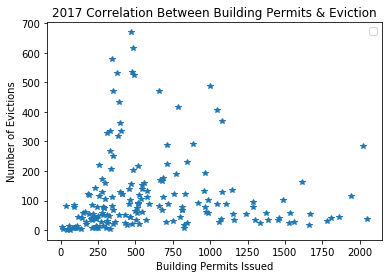

In [16]:
plt.plot(df_2017['Permit Counts'].values,df_2017['Eviction Counts'].values,'*')
plt.legend()
plt.ylabel('Number of Evictions')
plt.xlabel('Building Permits Issued')
plt.title('2017 Correlation Between Building Permits & Eviction')

No handles with labels found to put in legend.


Text(0.5,1,'2018 Correlation Between Building Permits & Eviction')

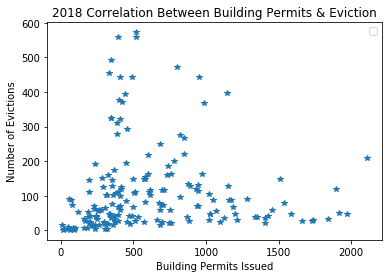

In [17]:
plt.plot(df_2018['Permit Counts'].values,df_2018['Eviction Counts'].values,'*')
plt.legend()
plt.ylabel('Number of Evictions')
plt.xlabel('Building Permits Issued')
plt.title('2018 Correlation Between Building Permits & Eviction')

As you can see based upon the visualizations above, there does not appear to be a very strong correlation between the number of building permits that have been issued and eviction notices issued.

## Conclusion of Findings

In [18]:
p_value = (stats.linregress(df_2017['Permit Counts'].values,df_2017['Eviction Counts'].values).pvalue)/2
p_value

0.4195435580919319

$$H_o : p=0$$
$$H_a : p>0$$ 
$$\alpha = .05$$ 
$$\text{p_value = 0.4195435580919319}$$
$$\text{The p-value for a one-tailed test is greater than the value for } \alpha$$
$$\text{Because the p-value is greater than } \alpha \text{, it suggests that there is not enough evidence to reject } H_o \text{ and the result is statistically nonsignificant}$$

In [19]:
p_value = (stats.linregress(df_2018['Permit Counts'].values,df_2018['Eviction Counts'].values).pvalue)/2
p_value

0.4195103003118487

$$H_o : p=0$$
$$H_a : p>0$$ 
$$\alpha = .05$$ 
$$\text{p_value = 0.4195103003118487}$$
$$\text{The p-value for a one-tailed test is greater than the value for } \alpha$$
$$\text{Because the p-value is greater than } \alpha \text{, it suggests that there is not enough evidence to reject } H_o \text{ and the result is statistically nonsignificant}$$

To conclude, using both 2017 and 2018 data, I cannot reject the null hypothesis that there is no correlation between the number of building permits issued and the number of eviction notices issued. In this experiment, I used a simple linear model, because I am assuming a lot of normality in the data distribution. Otherwise, it would have been more appropriate to perform a non-parametric test.

## Potential Future Work 

One potential way to delve further into this experiment in the future would be to analyze all of the job type and work types in the building permits dataset. Choosing specifc values of these categories to perform the same experiment on may yield stronger correlations with the number of eviction notices issued. It is possible that some categories simply have no correlation and are skewing the linear model by creating "noise". An example of this would be perhaps the job type "A2" which is "an application with multiple types of work that do not affect the use, egress, or occupancy of the building" is much more strongly correlated with eviction notices issued than say "DM" which is for demolition.